# **Tutorial 1: Loading and Sampling Trajectory Data**

## Getting started

Real-world mobility files vary widely in structure and formatting. Timestamps may be recorded as UNIX integers or ISO-formatted strings, with or without timezone offsets. Coordinate columns may follow different naming conventions, and files may be stored either as flat CSVs or as partitioned Parquet directories. This notebook demonstrates how `nomad.io.base` standardizes data loading across these variations using two example datasets: a CSV file (`gc-data.csv`) and a partitioned Parquet directory (`gc-data/`). For visualization, we will also use a dataset with building geometries underlying the synthetic data in these examples. Namely, the file `garden_city.geojson`.

## Inspecting schemas
Let's start by inspecting the schemas of the datasets we will use with the nomad helper function `table_columns` from the `io` module. This method reports column names for both flat files and partitioned datasets without reading the full content into memory.

In [1]:
from nomad.io import base as loader

print(loader.table_columns("gc_data.csv", format="csv"))
print(loader.table_columns("gc_data/", format="csv")) 

Index(['identifier', 'device_lon', 'device_lat', 'unix_timestamp',
       'local_datetime', 'date', 'ha'],
      dtype='object')
Index(['user_id', 'longitude', 'latitude', 'timestamp', 'datetime', 'ha',
       'date'],
      dtype='object')


## Typical processing with `pandas`, `geopandas`

When analyzing a manageable sample of data, pandas and geopandas provide excellent functionalities that allow you to do preliminary analysis and plotting without many additional tools. Suppose we want to perform some preliminary analysis of the data in (`gc-data.csv`). Suppose we would like to
- Load the trajectory and geometry data from disk. (using `pandas.read_csv()` and `geopandas.read_file()`)
- Plot the data of a user for a given day. (using `geopandas.plot()` and `matplotlib.pyplot.plot()`)
- Create a heatmap of certain areas with a lot of pings. (for this we could use a tessellation, for example `h3`).
- Analyze if there are gaps in the user's signals. (likely with a simple histogram from `matplotlib`)

For example, we can do it like this

In [2]:
import pandas as pd
import geopandas as gpd

# read data
df = pd.read_csv("gc_data.csv")
city = gpd.read_file("garden_city.geojson")

df.head()

,identifier,device_lon,device_lat,unix_timestamp,local_datetime,date,ha
0,cocky_stallman,-38.318802,36.669894,1704114435,2024-01-01 09:07:15-04:00,2024-01-01,8.492856
1,cocky_stallman,-38.318765,36.669905,1704114753,2024-01-01 09:12:33-04:00,2024-01-01,11.336772
2,cocky_stallman,-38.318627,36.669856,1704114792,2024-01-01 09:13:12-04:00,2024-01-01,18.436612
3,cocky_stallman,-38.318661,36.669920,1704114989,2024-01-01 09:16:29-04:00,2024-01-01,27.370737
4,cocky_stallman,-38.318602,36.669823,1704115195,2024-01-01 09:19:55-04:00,2024-01-01,12.506606


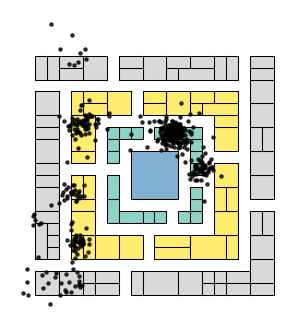

In [3]:
import matplotlib.pyplot as plt

# Plot trajectory data of a single user
user = df['identifier'].iloc[0]
user_df = df.loc[(df['identifier'] == user) & (df['date'] == '2024-01-04')]

# Plot trajectory
fig, ax1 = plt.subplots(figsize=(4,4))
ax1.set_axis_off()

city.plot(ax=ax1, column='type', edgecolor='black', linewidth=0.75, cmap='Set3')
ax1.scatter(user_df['device_lon'], user_df['device_lat'], s=5, alpha=0.75, color='black')

plt.show()

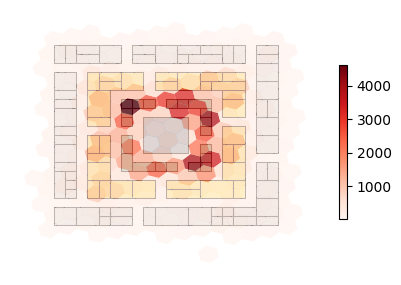

In [4]:
## Plot an h3 heatmap of ping hotspots.
#  For this task we can leverage `h3.latlng_to_cell` and `h3.cell_to_boundary` to get a cell's polygon
#  'Sharp edge # 1' the order of latitude and longitude depends on the library. We need to switch the order!
import h3
from shapely import Polygon

# Switch lat, lon to lon, lat and pass to shapely Polygon
def h3_cell_to_polygon(cell):
    coords = h3.cell_to_boundary(cell)
    lat, lon = zip(*coords)
    return Polygon(zip(lon, lat))

# Cell for each row
def row_to_h3_cell(row, res):
    return h3.latlng_to_cell(lat=row['device_lat'], lng=row['device_lon'], res=res)

df['cell'] = df.apply(row_to_h3_cell, res=12, axis=1)

pings_per_cell = df.groupby('cell').agg(pings=('unix_timestamp', 'count')).reset_index()
cell_geometries = pings_per_cell['cell'].apply(h3_cell_to_polygon)

h3_gdf = gpd.GeoDataFrame(pings_per_cell, geometry=cell_geometries)
h3_gdf = h3_gdf.loc[h3_gdf.pings>5] # Try 800

fig, ax2 = plt.subplots(figsize=(5,4))
city.plot(ax=ax2, column='type', edgecolor='black', linewidth=0.75, cmap='Set3') 
h3_gdf.plot(column=h3_gdf.pings, cmap='Reds', alpha=0.75, ax=ax2, legend=True, legend_kwds={'shrink': 0.5}) # try cmap='inferno' or 'plasma'
ax2.set_axis_off()
plt.show()

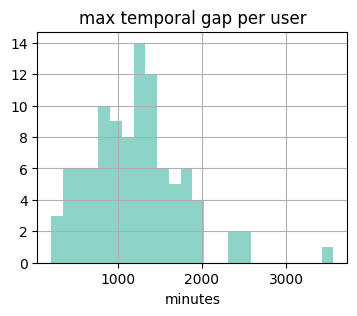

In [5]:
## Let's find the maximum temporal gap in the trajectory of each user
# A simple pandas groupby on the unix_timestamp column (in seconds since epoch)
def get_max_gap_minutes(times):
    shifted_times = times.shift(1, fill_value=0) # shift gives previous value
    gaps = (times.iloc[1:] - shifted_times.iloc[1:])//60 # gaps in minutes
    return gaps.max()

max_gap = df.groupby('identifier')['unix_timestamp'].apply(get_max_gap_minutes)

fig, ax3 = plt.subplots(figsize=(4,3))
max_gap.hist(ax=ax3, bins=24, color='#8dd3c7')
ax3.set_xlabel('minutes')
ax3.set_title('max temporal gap per user')
plt.show()

## Data ingestion with `nomad` — default type casting and a reusable pipeline

Here, we explore which advantages (if any) we can get from using `nomad` for the same preliminary analysis. In the case of reading a single csv file, the reader function `nomad.io.base.from_file` is basically a `pandas` wrapper, except that it facilitates the parsing of spatiotemporal columns which are known to follow specific formatting, for instance:

- dates and datetimes in ISO format are cast to `pandas.datetime64`
- unix timestamps are cast to integers
- user identifiers are cast to strings
- coordinates are cast to float

For such typecasting and other methods, `nomad` relies on a user provided mapping from "default" column names, to the column names in the data, namely, the dictionary `traj_cols`. This prevents having to rename columns *ad hoc* to reuse code, and simplifies the number of arguments passed to different methods. 


In [6]:
# These are the possible default column names that could be mapped to data columns to methods in `nomad` 
from nomad.constants import DEFAULT_SCHEMA
DEFAULT_SCHEMA

{'user_id': 'user_id',
 'latitude': 'latitude',
 'longitude': 'longitude',
 'datetime': 'datetime',
 'start_datetime': 'start_datetime',
 'end_datetime': 'end_datetime',
 'start_timestamp': 'start_timestamp',
 'end_timestamp': 'end_timestamp',
 'timestamp': 'timestamp',
 'date': 'date',
 'utc_date': 'date',
 'x': 'x',
 'y': 'y',
 'geohash': 'geohash',
 'tz_offset': 'tz_offset',
 'duration': 'duration',
 'ha': 'ha',
 'location_id': 'location_id'}

<a id='hidden-cell'></a>

A problem that can arise when analyzing data using just `pandas` is that the geospatial data is often partitioned, e.g. stored in smaller csv chunks in partitioned directories (e.g. `date=2024-01-01/`). Rather than reading the data with a for loop (and turning the partitioning directories into variables), `nomad`'s `from_file` can read a whole directory with the same function call, by warpping `PyArrow`'s file reader.

Let's replicate the previous analysis starting with `nomad`'s file reader on the partitioned dataset.

In [7]:
# For the single csv dataset
traj_cols = {"user_id": "identifier",
             "timestamp": "unix_timestamp",
             "latitude": "device_lat",
             "longitude": "device_lon",
             "datetime": "local_datetime",
             "date": "date"}
file_path = "gc_data.csv"

df = loader.from_file(file_path, format="csv", traj_cols=traj_cols)
# check data types
#print(df.dtypes)

In [8]:
# For the partitioned dataset
traj_cols = {"user_id": "user_id",
             "timestamp": "timestamp",
             "latitude": "latitude",
             "longitude": "longitude",
             "datetime": "datetime",
             "date": "date"} # the dataset has default column names
file_path = "gc_data/" # partitioned

# Try traj_cols=None. It should work because of default names
# Try mixed_timezone_behavior="utc" or "object", or parse_dates = False and inspect df
df = loader.from_file(file_path, format="csv", traj_cols=traj_cols, parse_dates=True)
# check data types
print(df.dtypes)

user_id              object
longitude           float64
latitude            float64
timestamp             Int64
datetime     datetime64[ns]
ha                  float64
date                 object
tz_offset             Int64
dtype: object


In [11]:
## Compute all three statistics as before 

# Trajectory of a single user
user = df[traj_cols['user_id']].iloc[0]
user_df = df.loc[(df[traj_cols['user_id']] == user) & (df[traj_cols['date']] == '2024-01-04')]

# Pings per cell geodataframe # TO DO: filters.to_h3
df["cell"] = df.apply(
    lambda r: h3.latlng_to_cell(lat=r[traj_cols["latitude"]], lng=r[traj_cols["longitude"]], res=12),
    axis=1)

pings_per_cell = df.groupby('cell').agg(pings=(traj_cols['timestamp'], 'count')).reset_index()
h3_gdf = gpd.GeoDataFrame(pings_per_cell, geometry=pings_per_cell['cell'].apply(h3_cell_to_polygon))
h3_gdf = h3_gdf.loc[h3_gdf.pings>5]

# Maximum gap for each user
max_gap = df.groupby(traj_cols['user_id'])[traj_cols['timestamp']].apply(get_max_gap_minutes)

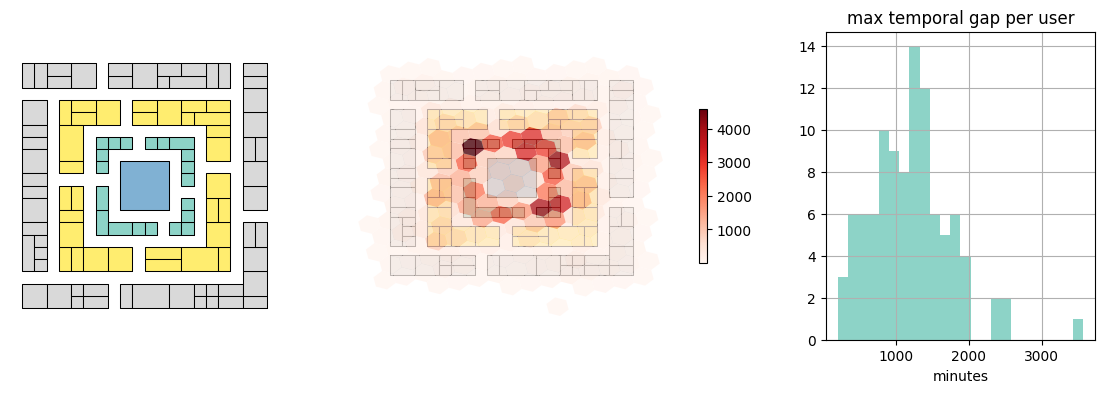

In [12]:
## Plotting
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3, width_ratios=[4.5, 7, 4.5])

# trajectory of a single user
city.plot(ax=ax1, column='type', edgecolor='black', linewidth=0.75, cmap='Set3')
ax1.scatter(user_df[traj_cols["longitude"]], user_df[traj_cols["latitude"]], s=6, alpha=0.75, color='black')
ax1.set_axis_off()
# heatmap
city.plot(ax=ax2, column='type', edgecolor='black', linewidth=0.75, cmap='Set3')
h3_gdf.plot(column=h3_gdf.pings, cmap='Reds', alpha=0.75, ax=ax2, legend=True, legend_kwds={'shrink': 0.5})
ax2.set_axis_off()
# gaps
max_gap.hist(ax=ax3, bins=24, color='#8dd3c7')
ax3.set_xlabel('minutes')
ax3.set_title('max temporal gap per user')

plt.show()

Now, go back to (hidden) [cell 7](#hidden-cell) and try simply changing the file path and column name mapping (traj_cols). The rest of the code works the same. 

## A good practice: prototype on a small sample, scale up later

While a researcher is still exploring and designing their experiments, it can be impractical, time consuming, or outright intractable, to use the entire dataset. Thus, it is recommended to work on a sample of the data, either by selecting some users at random, some records at random, or both. `nomad`'s `io.base.sample_users` selects a reproducible subset of user IDs, while `io.base.sample_from_file` reads the data of only those users, optionally sampling records. The resulting sample can be written to disk using `io.base.to_file`. 

When persisting the sample, we partition by `date` again to preserve the likeness with the original dataset. Reading the output back with `from_file` confirms that the sample was saved correctly and remains compatible with the same loading functions.

In [18]:
file_path = "gc_data/" # has default names
fmt = "csv"

# full data
df = loader.from_file(file_path, format=fmt)

# sample users
users = loader.sample_users(file_path, format=fmt, size=12, seed=314) # change if user_id has other name
# sample data, pass users
sample_df = loader.sample_from_file(file_path, users=users, format=fmt, frac_records=0.30, seed=314)

## optionally try uncommenting this line
# sample_df = loader.sample_from_file(file_path, users=users, format=fmt, frac_records=0.30, frac_users=0.12, seed=314)

# persist to parquet

loader.to_file(sample_df, "/tmp/nomad_sample2/", format=fmt, partition_by=["date"], existing_data_behavior='overwrite_or_ignore')
round_trip = loader.from_file("/tmp/nomad_sample2/", format=fmt)

C:\Users\franc\Documents\Nomad\nomad-repo\nomad\io\base.py:563: UserWarning: The 'datetime' column has timezone-naive records consider localizing or using unix timestamps.
  warnings.warn(f"The '{col}' column has timezone-naive records consider localizing or using unix timestamps.")


In [19]:
print("- Value counts for sample of data:\n")
print(round_trip.user_id.value_counts())
print("\n---------------------------------\n")
print("- Value counts for original data:\n")
print(df.user_id.value_counts())

- Value counts for sample of data:

user_id
dazzling_bose        851
sad_hugle            846
youthful_mayer       822
lucid_bartik         761
competent_cori       512
happy_panini         488
goofy_shockley       326
pensive_saha         223
optimistic_agnesi    168
brave_euler          164
youthful_meninsky    137
upbeat_boyd           89
Name: count, dtype: int64

---------------------------------

- Value counts for original data:

user_id
vigilant_mendeleev        6015
optimistic_curran         5881
cocky_stallman            3722
practical_jepsen          3488
adoring_khorana           2949
                          ... 
friendly_blackwell         310
nifty_almeida              291
gallant_jones              290
inspiring_visvesvaraya     289
determined_allen           221
Name: count, Length: 100, dtype: int64
